# Rhyme

In [1]:
# !pip install -r ../requirements.txt
import sys
sys.path.append('../')
from generative_formalism import *

In [2]:
def get_df_genai():
    df_prompts=get_rhyme_for_sample().assign(source='genai')
    excl_models = {'llama2-uncensored:7b', 'ollama/llama2-uncensored:latest','ollama/darkmoon/olmo:7B-instruct-q6-k','ollama/deepseek-r1:8b'}

    def get_model_renamed(x):
        if 'gpt-3' in x:
            return 'ChatGPT'
        if 'gpt-4' in x:
            return 'ChatGPT'
        elif 'claude-3' in x:
            return 'Claude'
        elif 'llama3' in x:
            return 'Llama'
        elif 'olmo2' in x:
            return 'Olmo'
        elif 'deepseek' in x:
            return 'DeepSeek'
        elif 'gemini' in x:
            return 'Gemini'
        else:
            return x

    def get_model_cleaned(x):
        return x.split('/')[-1].strip().title().split('-20')[0].split(':')[0].replace('Gpt-','GPT-').split('-Chat')[0]

    df_prompts = df_prompts[~df_prompts.model.isin(excl_models)]
    df_prompts['model9'] = df_prompts.model.apply(get_model_cleaned)
    df_prompts['period'] = df_prompts.model.apply(get_model_renamed)
    df_prompts['subcorpus'] = df_prompts.prompt_type
    df_prompts['rhyme'] = [('y' if 'DO_rhyme' == x else ('n' if 'do_NOT_rhyme' == x else '?')) for x in df_prompts.prompt_type]
    df_prompts.rhyme.value_counts()
    return df_prompts

In [3]:
def get_df_both():

    df_corpus=get_rhyme_for_sample('../data/corpus_sample_by_period.csv.gz').assign(source='corpus')
    df_prompts=get_df_genai()


    df_both = pd.concat([df_corpus.assign(source='Historical poems'), df_prompts.assign(source='Generative poems')]).fillna('')

    subcorpus_names = {
        '': '(n/a)',
        'DO_rhyme': 'Rhymed',
        'do_NOT_rhyme': 'Unrhymed',
        'MAYBE_rhyme': 'Rhyme unspecified',
    }
    df_both['prompt_type'] = df_both.prompt_type.apply(lambda x: subcorpus_names.get(x,x))
    df_both['subcorpus'] = [f'{y}: {subcorpus_names.get(x,x)}' for x, y in zip(df_both.subcorpus, df_both.source)]
    return df_both

In [4]:
df_both = get_df_both()
df_both.period.value_counts()

AttributeError: 'str' object has no attribute 'fillna'

In [ ]:
def get_avgs_df2(df, gby=['period','source','prompt_type'], y='rhyme_pred_perc'):
    stats_df = df.groupby(gby)[y].agg(
        mean=np.mean,
        stderr=lambda x: x.std() / np.sqrt(len(x)),
        count=len
    ).reset_index()
    return stats_df

In [ ]:
get_avgs_df2(df_both)

,period,source,prompt_type,mean,stderr,count
0,1600-1650,Historical poems,(n/a),91.251272,0.901646,983
1,1650-1700,Historical poems,(n/a),89.606458,0.969915,991
2,1700-1750,Historical poems,(n/a),88.376754,1.015045,998
3,1750-1800,Historical poems,(n/a),87.298387,1.057781,992
4,1800-1850,Historical poems,(n/a),86.900000,1.067487,1000
...,...,...,...,...,...,...
21,Llama,Generative poems,Rhymed,96.551724,0.529386,1189
22,Llama,Generative poems,Unrhymed,24.667189,1.206776,1277
23,Olmo,Generative poems,Rhyme unspecified,97.041420,0.652181,676
24,Olmo,Generative poems,Rhymed,93.428345,0.697505,1263


In [ ]:
df_corpus=get_rhyme_for_sample('../data/corpus_sample_by_period.csv.gz').assign(source='corpus')
df_corpus_avg = get_avgs_df2(df_corpus, gby=['period', 'subcorpus']).set_index(['period', 'subcorpus']).sort_index().round(2)[['count','mean','stderr']]
df_corpus_avg.columns = ['Number of poems', 'Percent rhyming poems', 'Standard error']
df_corpus_avg.to_latex('table_corpus.tex')
df_corpus_avg

Number of poems  Percent rhyming poems  Standard error
period    subcorpus                                                                       
1600-1650 American Poetry                        41                  95.12            3.41
          English Poetry                        942                  91.08            0.93
1650-1700 American Poetry                        11                  81.82           12.20
          English Poetry                        980                  89.69            0.97
1700-1750 American Poetry                        15                  93.33            6.67
...                                             ...                    ...             ...
1950-2000 African-American Poetry               128                   3.12            1.54
          American Poetry                       302                   0.99            0.57
          English Poetry                        339                   8.26            1.50
          Modern Poetry                         147                  23.13            3.49
          The Faber Poetry Library               84                   1.19            1.19

[27 rows x 3 columns]

In [ ]:
df_meta=get_chadwyck_corpus()

In [ ]:
df_corpus_avg2 = pd.DataFrame([
    {
        'period': period, 
        'subcorpus':subcorpus,
        'num_poets_total': df_meta.query(f'subcorpus=="{subcorpus}" & period=="{period}"').author.nunique(),
        'num_poets': gdf.author.nunique(),
        'num_poems_total': len(df_meta.query(f'subcorpus=="{subcorpus}" & period=="{period}"')),
        'num_poems': len(gdf),
        }
    for (period,subcorpus),gdf in df_corpus.groupby(['period','subcorpus'])
]).set_index(['period', 'subcorpus']).sort_index().round(2)

# convert numbers to comma'd strings
def format_number(x):
    x=int(x)
    return f'{x:,.0f}'

df_corpus_avg2 = df_corpus_avg2.applymap(format_number)

df_corpus_avg2.rename_axis(['Period', 'Subcorpus'], inplace=True)
df_corpus_avg2.columns = ['# Poets (corpus)', '# Poets (sample)', '# Poems (corpus)', '# Poems (sample)']
df_corpus_avg2.to_latex('table_corpus_avg2.tex')
df_corpus_avg2

# Poets (corpus) # Poets (sample) # Poems (corpus) # Poems (sample)
Period    Subcorpus                                                                                   
1600-1650 American Poetry                        10                5              404               41
          English Poetry                        248              126           15,002              942
1650-1700 American Poetry                         6                2              108               11
          English Poetry                        247              120           10,873              980
1700-1750 American Poetry                        16                7              487               15
...                                             ...              ...              ...              ...
1950-2000 African-American Poetry                10               10              863              128
          American Poetry                        45               43            2,505              302
          English Poetry                         27               25            3,027              339
          Modern Poetry                          21               18            1,195              147
          The Faber Poetry Library               11               10              706               84

[27 rows x 4 columns]

In [ ]:
df_table = df_both.copy()
df_table['prompt'] = [period if not prompt else prompt for period, prompt in zip(df_table.period, df_table.prompt)]
# df_table['prompt_type'] = [subcorpus if not prompt_type else prompt_type for subcorpus, prompt_type in zip(df_table.subcorpus, df_table.prompt_type)]
df_table_avg = get_avgs_df2(df_table, gby=['prompt_type','prompt']).set_index(['prompt_type','prompt']).sort_index().sort_values(['prompt_type','mean'],ascending=[True,False]).round(2)[['count','mean','stderr']]
df_table_avg.columns = ['Number of poems', 'Percent rhyming poems', 'Standard error']
# df_table_avg.to_latex('table.tex')
df_table_avg

Number of poems  Percent rhyming poems  Standard error
prompt_type prompt                                                                                                    
(n/a)       1600-1650                                                       983                  91.25            0.90
            1650-1700                                                       991                  89.61            0.97
            1700-1750                                                       998                  88.38            1.02
            1750-1800                                                       992                  87.30            1.06
            1800-1850                                                      1000                  86.90            1.07
...                                                                         ...                    ...             ...
Unrhymed    Write an unrhymed poem.                                         620                  47.90            2.01
            Write a poem (with 20+ lines) that does NOT rhyme.              809                  46.11            1.75
            Write a poem that does NOT rhyme.                               634                  39.75            1.95
            Write a short poem that does NOT rhyme.                         199                  37.19            3.43
            Write a poem in free verse.                                     674                  29.97            1.77

[31 rows x 3 columns]

In [ ]:
df_prompts = get_df_both().copy().query('prompt!=""')
df_prompts_stats = pd.DataFrame([
    {
        'model': model, 
        'prompt_type':prompt_type,
        'num_poems': len(gdf),
        'num_prompts': gdf.prompt.nunique(),
        'num_poems_per_prompt': int(round(len(gdf) / gdf.prompt.nunique())),
        }
    for (model,prompt_type),gdf in df_prompts.groupby(['model9','prompt_type'])
])
df_prompts_stats['prompt_type'] = pd.Categorical(df_prompts_stats['prompt_type'], categories=['Rhymed','Unrhymed','Rhyme unspecified'])
df_prompts_stats = df_prompts_stats.set_index(['prompt_type','model']).sort_index().rename_axis(['Prompt type', 'Model'])[['num_poems', 'num_poems_per_prompt']]
df_prompts_stats.columns = ['\# Poems', 'Avg. \# poems per prompt']
df_prompts_stats.to_latex('table_gen_prompts.tex')
df_prompts_stats

\# Poems  Avg. \# poems per prompt
Prompt type       Model                                              
Rhymed            Claude-3-Haiku        513                        64
                  Claude-3-Opus         447                        50
                  Claude-3-Sonnet       446                        50
                  Deepseek              256                        28
                  GPT-3.5-Turbo         583                        65
...                                     ...                       ...
Rhyme unspecified GPT-3.5-Turbo         405                        68
                  GPT-4-Turbo           412                        69
                  Gemini-Pro             75                        12
                  Llama3.1              739                       123
                  Olmo2                 676                       113

[27 rows x 2 columns]

In [ ]:
df_prompts = get_df_both().copy().query('prompt!=""')
df_prompts_stats = pd.DataFrame([
    {
        'model': model, 
        'prompt_type':prompt_type,
        'num_poems': len(gdf),
        'num_prompts': gdf.prompt.nunique(),
        'num_poems_per_prompt': int(round(len(gdf) / gdf.prompt.nunique())),
        }
    for (model,prompt_type),gdf in df_prompts.groupby(['model9','prompt_type'])
])
df_prompts_stats['prompt_type'] = pd.Categorical(df_prompts_stats['prompt_type'], categories=['Rhymed','Unrhymed','Rhyme unspecified'])
df_prompts_stats = df_prompts_stats.pivot_table(index='model', columns='prompt_type', values='num_poems', aggfunc='sum')
df_prompts_stats.to_latex('table_gen_prompts_pivot.tex')
df_prompts_stats
# df_prompts_stats.columns = ['\# Poems', 'Avg. \# poems per prompt']

prompt_type,Rhymed,Unrhymed,Rhyme unspecified
model,,,
Claude-3-Haiku,513,202,311
Claude-3-Opus,447,186,330
Claude-3-Sonnet,446,183,358
Deepseek,256,244,168
GPT-3.5-Turbo,583,896,405
GPT-4-Turbo,529,197,412
Gemini-Pro,48,808,75
Llama3.1,1189,1277,739
Olmo2,1263,1102,676


In [ ]:
df_prompts = get_df_both().copy().query('prompt!=""')
df_prompts_stats = pd.DataFrame([
    {
        'prompt_type':prompt_type,
        'prompt':prompt,
        'num_poems': len(gdf),
        # 'num_models': gdf.model9.nunique(),
        'num_poems_per_model': int(round(len(gdf) / gdf.model9.nunique())),
        }
    for (prompt_type,prompt),gdf in df_prompts.groupby(['prompt_type','prompt'])
])
df_prompts_stats['prompt_type'] = pd.Categorical(df_prompts_stats['prompt_type'], categories=['Rhymed','Unrhymed','Rhyme unspecified'])
df_prompts_stats = df_prompts_stats.set_index(['prompt_type','prompt']).sort_index().rename_axis(['Prompt type', 'Prompt'])[['num_poems', 'num_poems_per_model']]
df_prompts_stats.columns = ['\# Poems', 'Avg. \# poems per model']
df_prompts_stats.to_latex('table_gen_prompts_models.tex')
df_prompts_stats

\# Poems  Avg. \# poems per model
Prompt type       Prompt                                                                               
Rhymed            Write a long poem that does rhyme.                       742                       82
                  Write a poem (with 20+ lines) that rhymes.               761                       85
                  Write a poem in ballad stanzas.                          691                       77
                  Write a poem in heroic couplets.                         555                       62
                  Write a poem in the style of Emily Dickinson.            646                       72
                  Write a poem that does rhyme.                            548                       61
                  Write a short poem that does rhyme.                      157                       22
                  Write an rhyming poem.                                   508                       56
                  Write an ryhmed poem in the style of Shakespear...       666                       74
Unrhymed          Write a long poem that does NOT rhyme.                   776                       86
                  Write a poem (with 20+ lines) that does NOT rhyme.       809                       90
                  Write a poem in blank verse.                             631                       70
                  Write a poem in free verse.                              674                       75
                  Write a poem in the style of Walt Whitman.               752                       84
                  Write a poem that does NOT rhyme.                        634                       70
                  Write a short poem that does NOT rhyme.                  199                       22
                  Write an unrhymed poem.                                  620                       69
Rhyme unspecified Write a long poem.                                       793                       88
                  Write a poem (with 20+ lines).                           753                       84
                  Write a poem in groups of two lines.                     419                       47
                  Write a poem in stanzas of 4 lines each.                 571                       63
                  Write a poem.                                            698                       78
                  Write a short poem.                                      240                       27

In [ ]:
get_avgs_df2(df_both, gby=['prompt_type'])[['prompt_type','mean']]

,prompt_type,mean
0,(n/a),66.951281
1,Rhyme unspecified,95.221647
2,Rhymed,95.240804
3,Unrhymed,49.578018


In [ ]:
get_avgs_df2(df_both, gby=['period','prompt_type'])[['prompt_type','period','mean']].query('prompt_type=="Unrhymed"')

,prompt_type,period,mean
10,Unrhymed,ChatGPT,18.389753
13,Unrhymed,Claude,45.884413
16,Unrhymed,DeepSeek,31.147541
19,Unrhymed,Gemini,93.688119
22,Unrhymed,Llama,24.667189
25,Unrhymed,Olmo,83.030853


In [ ]:
get_avgs_df2(df_both, gby=['period','prompt_type'])[['prompt_type','period','mean']].query('prompt_type=="Rhyme unspecified"')


,prompt_type,period,mean
8,Rhyme unspecified,ChatGPT,91.432069
11,Rhyme unspecified,Claude,93.093093
14,Rhyme unspecified,DeepSeek,98.214286
17,Rhyme unspecified,Gemini,96.000000
20,Rhyme unspecified,Llama,99.864682
23,Rhyme unspecified,Olmo,97.041420


In [ ]:
def plot_predicted_rhyme_avgs(df, y='rhyme_pred_perc', x='period', gby=['period','source'], color=None, limits=[0,100], min_size=10):
    figdf = get_avgs_df2(df, gby=gby, y=y)
    figdf['source'] = pd.Categorical(figdf.source, categories=['Historical poems', 'Generative poems'])
    periods = list(df[x].unique())
    figdf[x] = pd.Categorical(figdf[x], categories=sorted(periods, reverse=False))

    p = (
        p9.ggplot(
            figdf,
            p9.aes(
                x=x,
                y='mean',
                **({'color': color, 'group': color} if color else {})
            )
        )
        + p9.geom_line()
        + p9.geom_errorbar(
            p9.aes(ymin='mean - stderr',
                  ymax='mean + stderr'),
            width=0.5,
            # position=p9.position_dodge(width=0.5)
        )
        + p9.geom_point(p9.aes(size='count'), shape='o',alpha=.2)
        + p9.geom_hline(yintercept=50, color='black', linetype='dashed', size=.5, alpha=.5)
        + p9.theme(legend_position='bottom')
        + p9.theme_minimal()
        + p9.theme(panel_background=p9.element_rect(fill='white'), plot_background=p9.element_rect(fill='white'))
        + p9.scale_y_continuous(limits=limits)
    )

    return p

def plot_both(df_both, y='rhyme_pred_perc', gby=['period', 'rhyme', 'source'], color='rhyme'):
    p9.options.figure_size=(10,5)
    figdf = df_both[df_both.rhyme.isin({"y", "n", "?"})]
    figdf['rhyme']=figdf.rhyme.apply(lambda x: 'Yes rhyme' if x == 'y' else ('No rhyme' if x == 'n' else '(Unspecified)'))
    fig = (
        plot_predicted_rhyme_avgs(
            figdf,
            y=y,
            gby=gby,
            color=color,
        )
        + p9.theme(axis_text_x=p9.element_text(angle=45))
        + p9.facet_wrap("source", scales="free_x")
        + p9.labs(
            color='Prompt type',
            y='Predicted percentage of rhyming poems',
            x='Historical period / Generative model',
            title='Predicted percentage of rhyming poems by historical period and generative model',
            size='Number of poems'
        )
    )
    fig.save(f'../figures/predicted_rhyme_avgs_{y}_std.png')
    return fig

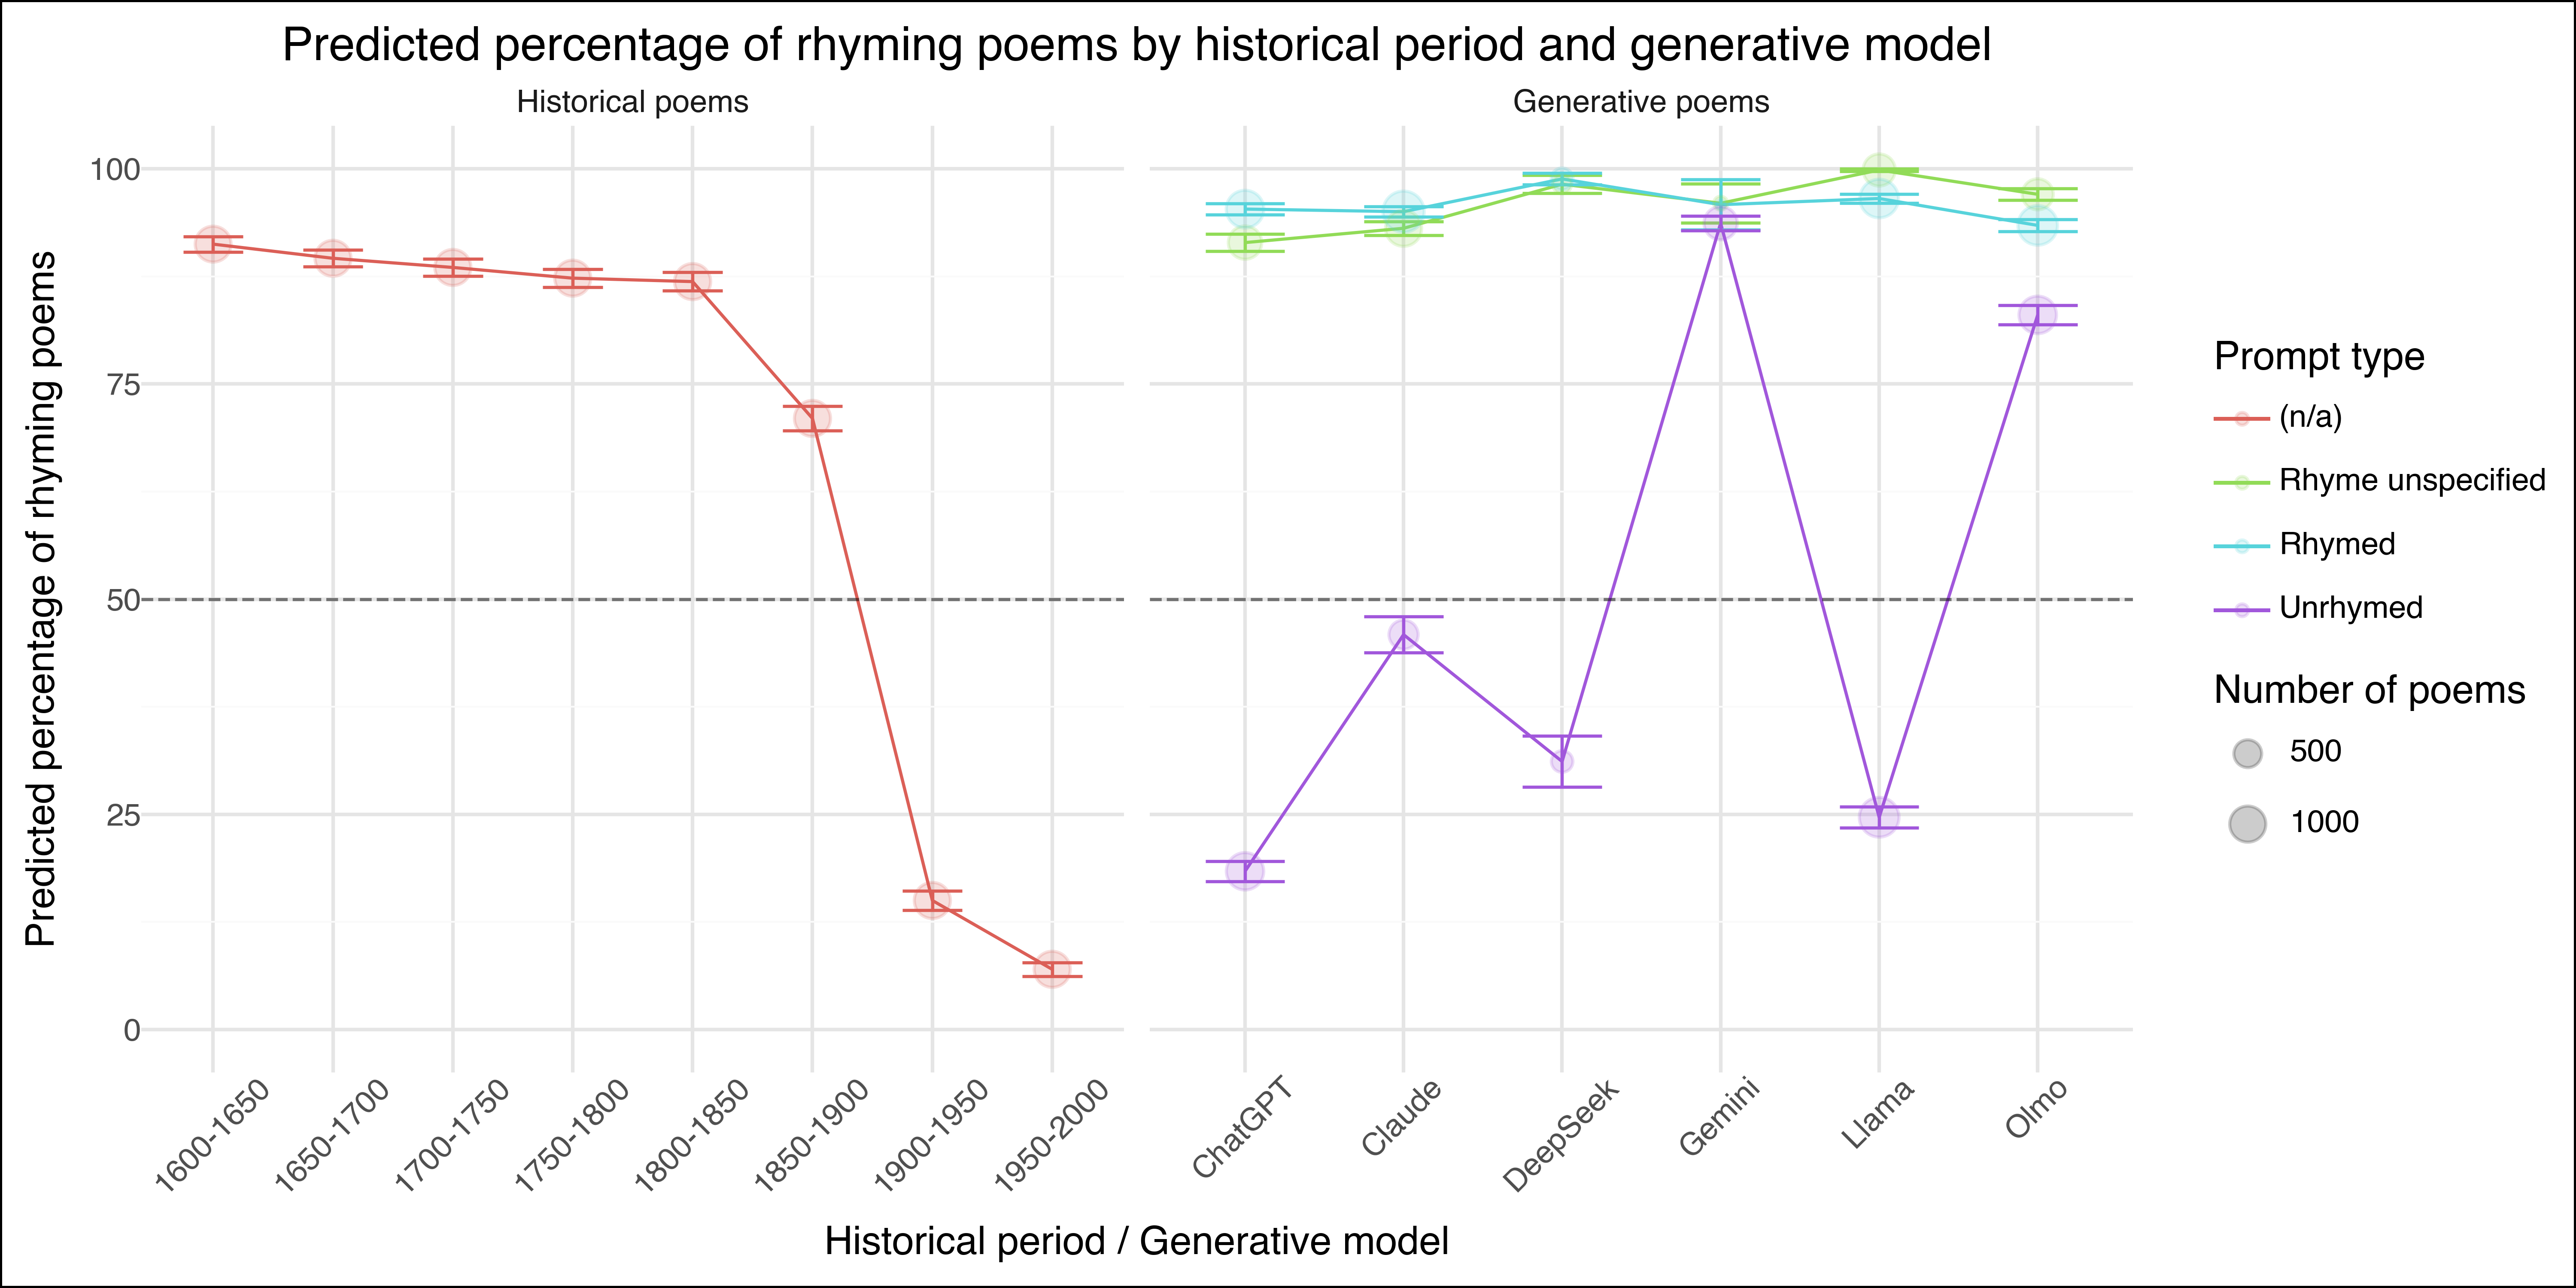

In [ ]:
plot_both(df_both, y='rhyme_pred_perc', gby=['period', 'prompt_type', 'source'], color='prompt_type')

## By prompt

In [ ]:
def plot_fig_avgs_prompts(x='prompt', color='period', model='ChatGPT-3.5 (OpenAI)', y='rhyme_pred_perc'):
    p9.options.figure_size=(16,10)
    figdf=df_both.query('source=="Generative poems"')
    # Convert mixed type columns to string to avoid comparison errors
    figdf[x] = figdf[x].astype(str)
    if color in figdf.columns:
        figdf[color] = figdf[color].astype(str)
    
    stats_df = get_avgs_df2(figdf, gby=[x, color], y=y)
    
    # prompts = list(figdf.sort_values('prompt_type').prompt.drop_duplicates())
    prompts = stats_df.groupby(x)['mean'].median().sort_values().index
    stats_df['prompt'] = pd.Categorical(stats_df['prompt'], categories=prompts)
    
    # Get unique prompt types and assign colors
    if 'prompt_type' in figdf.columns:
        prompt_types = figdf['prompt_type'].unique()
        Set1 = [
        # '#e41a1c',  # Red
        '#377eb8',  # Blue
        '#984ea3',  # Purple
        '#4daf4a',  # Green
        '#ff7f00',  # Orange
        '#ffff33',  # Yellow
        '#a65628',  # Brown
        '#f781bf',  # Pink
        '#999999'   # Gray
        ]
        prompt_type_colors = dict(zip(prompt_types, Set1))
        
        # Map prompts to their types and colors
        prompt_to_type = figdf.set_index('prompt')['prompt_type'].to_dict()
        prompt_colors = {prompt: prompt_type_colors[prompt_to_type[prompt]] 
                        for prompt in prompts if prompt in prompt_to_type}
    
    # Create the plot with error bars
    fig = (p9.ggplot(stats_df, p9.aes(x=x, y='mean'))
        # + p9.geom_point(
        #     p9.aes(size='count'),
        #     shape='o',
        #     alpha=.2
        # )
        + p9.geom_line(p9.aes(group=color), linetype='dashed', alpha=.5)
        + p9.geom_errorbar(
            p9.aes(
                ymin='mean - stderr',
                ymax='mean + stderr',
                # color=color,
                # group=color
            ),
            width=0.5,
            # position=p9.position_dodge(width=0.5)
        )
        + p9.labs(
            x='Model',
            y='Percentage of poems rhyming',
            title='Likelihood of rhyming poems across prompts'
        )
        + p9.theme_minimal()
        + p9.coord_flip()
        + p9.scale_y_continuous(limits=[0,100])
        + p9.geom_hline(yintercept=50, linetype='dashed', color='gray', alpha=.5)
        + p9.facet_wrap('period', nrow=2)
        + p9.theme(plot_background=p9.element_rect(fill='white'), panel_background=p9.element_rect(fill='white'))
    )
    
    # Customize axis text colors based on prompt_type
    if 'prompt_type' in figdf.columns:
        # Create a theme element to color the axis text
        colored_theme = p9.theme(
            axis_text_y=p9.element_text(color=[prompt_colors.get(tick, 'black') for tick in prompts])
        )
        fig = fig + colored_theme
    fig.save(f'../figures/rhyme_avgs_by_prompt.png')

    return fig

In [ ]:
plot_fig_avgs_prompts()